# Mục lục

1. [Giới thiệu](#intro)
2. [EDA](#eda)
3. [Xây dựng mô hình](#modeling)
    1. [Tiền xử lý](#preprocessing)
    2. [Chia dữ liệu](#datasplit)
    3. [Giới thiệu tfidf](#tfidf-intro)
    4. [Chuyển đổi sang tf-idf](#tfidf-appl)
    5. [Hồi quy logistic](#lg)
    6. [Kiểm soát (regularize)](#reg)
    7. [Xác thực (validating)](#valid)
4. [Diễn dịch mô hình](#interpret)
    1. [Odds](#odds)
    2. [Odds ratio](#odds-ratio)
5. [Tham khảo](#ref)

# (1) Giới thiệu <a name="intro"></a>

Nhận dạng bình luận độc hại (toxic comment classification).  
Bình luận độc hại là những bình luận:
* chửi tục
* phân biệt (vùng miền, giới tính)
* lăng mạ
* cổ súy bạo lực (vd: "hạng này bắn bỏ", "tử hình cả dòng họ nó").

Đầu vào là một bình luận đầu ra sẽ là một nhãn "0" hoặc "1" với "1" là bình luận độc hại và "0" là bình thường.

# (2) EDA<a name="eda"></a>

In [1]:
import pandas as pd
import numpy as np
from seaborn import countplot

In [2]:
raw_data = pd.read_csv("data/raw_data.csv")
raw_data.tail()

,id,comment,is_toxic
12671,12671,Bảo Bảo hum đúng là như lozz thật xem clip tắt...,1
12672,12672,Trần Hà hên là mày khôn ra,0
12673,12673,Bích Huyền chuyện dì cũng có thể xảy ra,0
12674,12674,Nguyễn Trân Trân dm t nhìn giống m vl :)),1
12675,12675,Nguyễn Trang mới đọc nãy,0


Dữ liệu thu được gồm 12675 bình luận. Gồm các trường id, comment, is_toxic.

In [3]:
ex = [raw_data.loc[98].comment, raw_data.loc[108].comment, raw_data.loc[1964].comment]
print(ex)

['Việt Trinh', 'Hương Gà k ck mình hơn mình 5t. Mệt lắm =)))))', '👉Nhận order mua hộ vận chuyện hàng Trung - Việt 😊\n👉 Hàng nội địa giá tận gốc.\n👉Chuyên sỉ (hàng có sẵn)\n\n😘Like Trang https://m.facebook.com/101837188158750/photos/a.101838121491990/103918364617299/?type=3&source=44 để cập nhật những món khoái khẩu nhé 🥰']


Dữ liệu comment có chứa tên riêng, từ viết tắt, emoji, url, sai chính tả, thiếu dấu, teencode.

<AxesSubplot:xlabel='is_toxic', ylabel='count'>

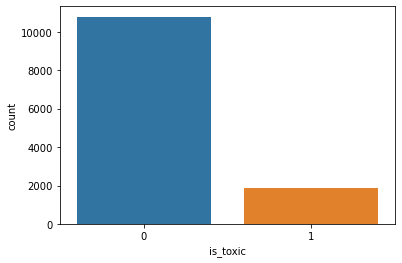

In [4]:
countplot(raw_data.is_toxic)

In [5]:
num_0, num_1 = raw_data.is_toxic.value_counts().values
print(f"Các bình luận độc hại chiếm {round(num_1 / (num_0 + num_1) * 100, 2)}% tổng số bình luận.")

Các bình luận độc hại chiếm 14.89% tổng số bình luận.


# (3) Xây dựng model<a name="modeling"></a>

## 3.A. Tiền xử lý<a name="preprocessing"></a>

Tiền xử lý bao gồm các việc được thực hiện tuần tự:
1. Bỏ khoảng trắng thừa, đưa về viết thường
2. Chuyển đổi chữ viết tắt sang đầy đủ, được thực hiện bằng cách dò từ điển (các bước thực hiện ở hình dưới)
3. Tách từ (tokenize). Sử dụng [VnCoreNLP wordsegmenter](https://github.com/vncorenlp/VnCoreNLP).
4. Bỏ từ sai chính tả, tiếng nước ngoài, .... Sử dụng bộ từ vựng lấy từ [miai.vn](https://www.miai.vn/thu-vien-mi-ai/), nếu từ không có trong bộ thì loại bỏ
5. Loại bỏ stop word. Danh sách stop word [tại đây](https://xltiengviet.fandom.com/wiki/Danh_s%C3%A1ch_stop_word)

![Abbreviation chart](img/abbreviation_chart.png)

In [6]:
from preprocess import preprocess_df

In [7]:
X = raw_data.drop(["id"], axis=1)

In [8]:
X_proc = preprocess_df(X)

In [9]:
X_proc = X_proc.replace("", np.NaN)
X_proc.isnull().sum()

comment     676
is_toxic      0
dtype: int64

In [10]:
X = raw_data.drop(["id"], axis=1)
X[X_proc.isnull().any(axis=1)]

,comment,is_toxic
43,Việt Nguyễn,0
71,dell hỉu,0
102,"""=))""",0
104,Nguyễn Thuỵ,0
112,Aretha Pham,0
...,...,...
12591,Vler,0
12595,Nacy Lê đúng r thì phải,0
12598,#ERROR!,0
12623,🤨)\n( ))\n/ \,0


Sau khi tiền xử lý có 700 bình luận bị trống, những bình luận này thường chỉ chứa toàn stop word, tagging, sai chính tả, thiếu dấu... hoặc chỉ chứa icon, emoji. Ta sẽ bỏ chúng đi.

In [11]:
X_proc = X_proc.dropna()
X_proc.to_csv("data/preprocessed_data.csv", index=False)
X = X_proc.reset_index().drop(["index"], axis=1)

In [12]:
X.tail()

,comment,is_toxic
11995,bảo bảo đúng lồn thật xem tắt,1
11996,trần hà hên mày khôn,0
11997,bích huyền chuyện dì xảy,0
11998,địt_mẹ tao nhìn giống mày vãi lồn,1
11999,mới đọc nãy,0


![Clean cloud](img/clean_cloud.png)
![Toxic cloud](img/toxic_cloud.png)

Word cloud sau khi đã qua tiền xử lý.

## 3.B. Chia dữ liệu<a name="datasplit"></a>

Chia dữ liệu ra làm 3 bộ train/valid/test theo tỉ lệ 6/2/2.  
Đầu tiên chia train (80%) và test (20%) theo bộ dữ liệu đầy đủ. Sau đó chia valid 25% từ bộ train.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
y = X.is_toxic.to_numpy()
X = X.drop(["is_toxic"], axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, 
                                                      random_state=41, stratify=y_train)

<AxesSubplot:xlabel='is_toxic', ylabel='count'>

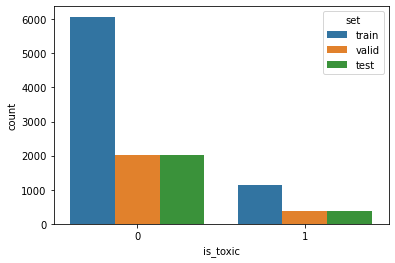

In [16]:
dftr = pd.DataFrame(data={"is_toxic": y_train, "set": ["train"] * len(y_train)})
dfva = pd.DataFrame(data={"is_toxic": y_valid, "set": ["valid"] * len(y_valid)})
dfte = pd.DataFrame(data={"is_toxic": y_test, "set": ["test"] * len(y_test)})
frame = [dftr, dfva, dfte]
ess = pd.concat(frame)
countplot(data=ess, hue="set", x="is_toxic")

## 3.C. Giới thiệu tf-idf<a name="tfidf-intro"></a>

Term frequency inverse document frequency được tính bằng công thức:  
$tf-idf(t, d) = tf(t, d) * idf(t)$

*t là chữ và d là bình luận.*

Theo sklearn **tf(t, d)** được tính bằng **CountVectorizer**. 

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [18]:
corpus = ["tôi đi học", "tôi đi chơi"]
exvec = CountVectorizer()
exvec.fit(corpus)
exvec.get_feature_names()

['chơi', 'học', 'tôi', 'đi']

In [19]:
ex = exvec.transform(corpus).toarray()
ex

array([[0, 1, 1, 1],
       [1, 0, 1, 1]])

**smooth_idf=False**  
$ idf(t) = log(\frac{n}{df(t)}) + 1 $

**smooth_idf=True**  
$ idf(t) = log(\frac{n + 1}{df(t) + 1}) + 1 $


*n là tổng số lượng các bình luận*  
*df(t) là số bình luận trong đó có chứa t*

In [20]:
transformer = TfidfTransformer()
transformer.fit(ex)
transformer.idf_

array([1.40546511, 1.40546511, 1.        , 1.        ])

$tf-idf(\text{"tôi đi học"}) = [0 * 1.41,  1 * 1.41,  1 * 1,  1 * 1] = [0. ,  1.41,  1,  1]$

Thư viện sklearn sau đó thực hiện **normalization** trên vector tf-idf bằng công thức:  
$v_{norm} = \frac{v}{\sqrt(v_{1}^{2} + v_{2}^{2} + ... + v_{n}^{2})} = [0., 0.7, 0.5, 0.5]$

In [21]:
transformer.transform(ex).toarray()

array([[0.        , 0.70490949, 0.50154891, 0.50154891],
       [0.70490949, 0.        , 0.50154891, 0.50154891]])

## 3.D. Thực hiện chuyển đổi sang tf-idf<a name="tfidf-appl"></a>

Trong sklearn có TfidfVectorizer tương đương với việc thực hiện CountVectorizer sau đó TfidfTransformer.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
corpus = X.comment.values
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=3000)
vectorizer.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [24]:
X_train_vec = vectorizer.transform(X_train.comment.values).toarray()
X_valid_vec = vectorizer.transform(X_valid.comment.values).toarray()
X_test_vec = vectorizer.transform(X_test.comment.values).toarray()
y_train = y_train
y_valid = y_valid
y_test = y_test

## 3.E. Hồi quy logistic<a name="lg"></a>

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
lg = LogisticRegression(solver="liblinear")
lg.fit(X_train_vec, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [27]:
from sklearn.metrics import f1_score, recall_score, precision_score

In [28]:
y_train_pred = lg.predict(X_train_vec)
y_valid_pred = lg.predict(X_valid_vec)
y_test_pred = lg.predict(X_test_vec)

In [29]:
print(f"Train f1: {f1_score(y_train, y_train_pred)}")
print(f"Train precision: {precision_score(y_train, y_train_pred)}")
print(f"Train recall: {recall_score(y_train, y_train_pred)}")
print(f"\nValid f1: {f1_score(y_valid, y_valid_pred)}")
print(f"Valid precision: {precision_score(y_valid, y_valid_pred)}")
print(f"Valid recall: {recall_score(y_valid, y_valid_pred)}")
print(f"\nTest f1: {f1_score(y_test, y_test_pred)}")
print(f"Test precision: {precision_score(y_test, y_test_pred)}")
print(f"Test recall: {recall_score(y_test, y_test_pred)}")

Train f1: 0.7443897099069514
Train precision: 0.9784172661870504
Train recall: 0.6007067137809188

Valid f1: 0.6573426573426573
Valid precision: 0.9641025641025641
Valid recall: 0.4986737400530504

Test f1: 0.6925675675675674
Test precision: 0.9534883720930233
Test recall: 0.5437665782493368


## 3.F. Cơ chế kiểm soát (regularization)<a name="reg"></a>

### L1 regularization

Tối ưu hàm mất mát sau: $\underset{\theta,c}{min}\frac{1}{2}\theta^{T}\theta+C\displaystyle\sum^{n}_{i=1}\log(\exp(-y_{i}(X_{i}^{T}\theta+c))+1)$

L1 loại bỏ các feature không quan trọng bằng cách cho $\theta$ tương ứng về 0.

In [30]:
import matplotlib.pyplot as plt

In [31]:
c_list = [0.12, 0.24, 0.48, 1.62, 2.88, 5.2, 10.12]
l1_f1_train = []
l1_f1_valid = []
l1_f1_test = []
for i in c_list:
    lg = LogisticRegression(random_state=41,
                        solver="liblinear",
                        C=i,
                        penalty="l1",
                        max_iter=1000)
    lg.fit(X_train_vec, y_train)
    y_train_pred = lg.predict(X_train_vec)
    y_valid_pred = lg.predict(X_valid_vec)
    y_test_pred = lg.predict(X_test_vec)
    l1_f1_train.append(f1_score(y_train, y_train_pred))
    l1_f1_valid.append(f1_score(y_valid, y_valid_pred))
    l1_f1_test.append(f1_score(y_test, y_test_pred))

### L2 regularization

Tối ưu hàm mất mát sau: $\underset{\theta,c}{min}\lvert\lvert{\theta}\rvert\rvert_{1}+C\displaystyle\sum^{n}_{i=1}\log(\exp(-y_{i}(X_{i}^{T}\theta+c))+1)$

L2 giảm $\theta$ của các feature không quan trọng về con số rất nhỏ.

In [32]:
c_list = [0.12, 0.24, 0.48, 1.62, 2.88, 5.2, 10.12]
l2_f1_train = []
l2_f1_valid = []
l2_f1_test = []
for i in c_list:
    lg = LogisticRegression(random_state=41,
                        solver="liblinear",
                        C=i,
                        penalty="l2",
                        max_iter=1000)
    lg.fit(X_train_vec, y_train)
    y_train_pred = lg.predict(X_train_vec)
    y_valid_pred = lg.predict(X_valid_vec)
    y_test_pred = lg.predict(X_test_vec)
    l2_f1_train.append(f1_score(y_train, y_train_pred))
    l2_f1_valid.append(f1_score(y_valid, y_valid_pred))
    l2_f1_test.append(f1_score(y_test, y_test_pred))

Text(0, 0.5, 'f1-score')

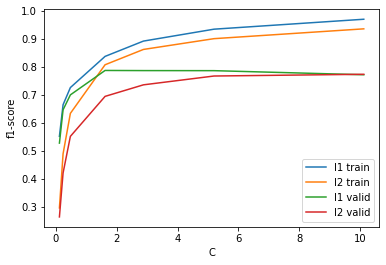

In [33]:
plt.plot(c_list, l1_f1_train, label="l1 train")
plt.plot(c_list, l2_f1_train, label="l2 train")
plt.plot(c_list, l1_f1_valid, label="l1 valid")
plt.plot(c_list, l2_f1_valid, label="l2 valid")
plt.legend(loc="lower right")
plt.xlabel("C")
plt.ylabel("f1-score")

Cả hai phương pháp tốt nhất khi $C \approx 1.8$ nhưng f1-score của L1 tốt hơn L2.

## 3.G. Xác thực (validating)<a name="valid"></a>

In [34]:
lg = LogisticRegression(random_state=41,
                        solver="liblinear",
                        C=1.8,
                        penalty="l1",
                        max_iter=1000)
lg.fit(X_train_vec, y_train)

LogisticRegression(C=1.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=41, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [35]:
y_train_pred = lg.predict(X_train_vec)
y_valid_pred = lg.predict(X_valid_vec)
y_test_pred = lg.predict(X_test_vec)

In [36]:
print(f"Train f1: {f1_score(y_train, y_train_pred)}")
print(f"Train precision: {precision_score(y_train, y_train_pred)}")
print(f"Train recall: {recall_score(y_train, y_train_pred)}")
print(f"\nValid f1: {f1_score(y_valid, y_valid_pred)}")
print(f"Valid precision: {precision_score(y_valid, y_valid_pred)}")
print(f"Valid recall: {recall_score(y_valid, y_valid_pred)}")
print(f"\nTest f1: {f1_score(y_test, y_test_pred)}")
print(f"Test precision: {precision_score(y_test, y_test_pred)}")
print(f"Test recall: {recall_score(y_test, y_test_pred)}")

Train f1: 0.8545190913484775
Train precision: 0.9434364994663821
Train recall: 0.7809187279151943

Valid f1: 0.7864823348694315
Valid precision: 0.9343065693430657
Valid recall: 0.6790450928381963

Test f1: 0.8183161004431314
Test precision: 0.9233333333333333
Test recall: 0.7347480106100795


Kết quả trên train test spilt ta được 0.78 trên tập valid và 0.81 trên tập test.

In [37]:
from sklearn.model_selection import StratifiedKFold

In [38]:
kX = vectorizer.transform(X.comment.values).toarray()
skf = StratifiedKFold(n_splits=10)
train_f1 = []
valid_f1 = []
for i, (train, valid) in enumerate(skf.split(kX, y)):
    print(f"[FOLD {i + 1}]")
    lg.fit(kX[train], y[train])
    y_tp = lg.predict(kX[train])
    y_vp = lg.predict(kX[valid])
    train_f1.append(f1_score(y[train], y_tp))
    valid_f1.append(f1_score(y[valid], y_vp))
    print(f"Train f1: {train_f1[-1]}")
    print(f"Valid f1: {valid_f1[-1]}\n")

[FOLD 1]
Train f1: 0.8585178055822907
Valid f1: 0.8168168168168168

[FOLD 2]
Train f1: 0.8561335902376365
Valid f1: 0.8035190615835777

[FOLD 3]
Train f1: 0.8576010262989096
Valid f1: 0.7964601769911505

[FOLD 4]
Train f1: 0.8557661419852233
Valid f1: 0.7976539589442815

[FOLD 5]
Train f1: 0.8571428571428571
Valid f1: 0.7833827893175075

[FOLD 6]
Train f1: 0.8595253367543297
Valid f1: 0.8126801152737754

[FOLD 7]
Train f1: 0.8572347266881029
Valid f1: 0.8093841642228738

[FOLD 8]
Train f1: 0.8540263073468078
Valid f1: 0.8362573099415205

[FOLD 9]
Train f1: 0.8544812078380983
Valid f1: 0.8255813953488371

[FOLD 10]
Train f1: 0.8531018964963034
Valid f1: 0.8200589970501475



In [39]:
print(f"Mean train f1: {np.mean(train_f1)} - Std train f1: {np.std(train_f1)}")
print(f"Mean valid f1: {np.mean(valid_f1)} - Std valid f1: {np.std(valid_f1)}")

Mean train f1: 0.856353089637056 - Std train f1: 0.0019387705144729413
Mean valid f1: 0.8101794785490488 - Std valid f1: 0.01474228194607023


Với 10-fold ta thấy kết quả mô hình là vào khoảng $0.81\pm0.01$.

# (4) Diễn dịch mô hình<a name="interpret"></a>

In [40]:
X_f = vectorizer.transform(X.comment.values).toarray()
lg.fit(X_f, y)

LogisticRegression(C=1.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=41, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
sum = 0
for coef in lg.coef_[0]:
    if coef != 0:
        sum += 1
print(f"l1 giảm số feature từ {len(lg.coef_[0])} còn {sum}")

l1 giảm số feature từ 3000 còn 431


## 4.A. Odds<a name="odds"></a>

$\text{odds} = \frac{P(y=1)}{P(y=0)} = exp(\sum_{i=0}^{n}\theta_{i}x_{i})$

Odds cho biết khả năng của một bình luận thuộc về lớp 1 cao hơn bao nhiêu lần so với lớp 0.

In [42]:
test_corp = {"comment": [
    "Từ nhỏ đến giờ tao chưa bao giờ ăn thịt chó:)))))) thề", 
    "Dắt bọn này đi bảo vệ Nô khỏi bị cướp tiền, nhưng ko cẩn thận có khi lại mất chó kaka 😄😆😆😂😂", 
    "H m thích gây war hả con chó"]}
test_df = pd.DataFrame(test_corp)
test_df = preprocess_df(test_df)
test_df_vec = vectorizer.transform(test_df.comment.values).toarray()

p = lg.predict_proba(test_df_vec)
odds = p[:, 1] / p[:, 0]

for i, c in enumerate(test_corp["comment"]):
    print(f"[Bình luận] {c}\n[odds] {odds[i]}\n")

[Bình luận] Từ nhỏ đến giờ tao chưa bao giờ ăn thịt chó:)))))) thề
[odds] 0.041818680692752096

[Bình luận] Dắt bọn này đi bảo vệ Nô khỏi bị cướp tiền, nhưng ko cẩn thận có khi lại mất chó kaka 😄😆😆😂😂
[odds] 0.1618186649148505

[Bình luận] H m thích gây war hả con chó
[odds] 1.671775424168421



Cả ba bình luận trên đều có từ chó, nhưng chỉ có bình luận thứ 3 là có ý công kích nên odd của nó cũng cao hơn hai bình luận còn lại.

## 4.B. Odds ratio<a name="odds-ratio"></a>

  $\text{odds ratio} = \frac{odds_{x_{i}+1}}{odds} = exp(\theta_{j})$

**odds ratio** của feature $x_{j}$ cho biết khả năng của bình luận thuộc về lớp 1 tăng thêm bao nhiêu nếu nó tăng thêm 1.

In [43]:
dic = {"word": vectorizer.get_feature_names(),
       "weight": lg.coef_[0],
       "odds_ratio": np.exp(lg.coef_[0])}
table = pd.DataFrame(dic)

In [44]:
table.sort_values(by=["odds_ratio"], axis=0, ascending=False).head()

,word,weight,odds_ratio
1214,lồn,25.421939,1.098014e+11
2822,đéo,17.290471,3.229656e+07
2916,địt,16.437255,1.375971e+07
2918,địt_mẹ,16.433529,1.370853e+07
568,cặc,15.409790,4.924778e+06


Ta thấy các từ chửi tục có odds ratio rất cao nên có thể kết luận mô hình đang làm đúng việc của nó.

In [45]:
from joblib import dump
dump(lg, 'lg.joblib')

['lg.joblib']

# (5) Tham khảo<a name="ref"></a>

1. https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
2. https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
3. https://christophm.github.io/interpretable-ml-book/logistic.html